## Notebook to generate the source file from each catalogue to perform the match
Provide it TOPCAT RA-DEC with full double precision.

In [1]:
from astropy.table import Table
from astropy.coordinates import Longitude
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
roots_tfm = '/home/julien/Documents/Etudes/Astrofisica/Master/TFM/Data'

In [2]:
filenames = ['SUSS6_ra_dec.fits','uvot_ra_dec.fits']
projects = ['XMM-Newton','Swift-UVOT']

In [3]:
def create_source_ra_dec_file(filepath):
    dat = Table.read(filepath)
    df = dat.to_pandas()

    # Treatment of points on the right ascension edge
    df_source_test = df.groupby('SRCNUM').agg({'RA' : 'std'})
    ind_src_ra_err = df_source_test[df_source_test['RA']>10].index
    if len(ind_src_ra_err)>0:
        ind_ra_err = (df['SRCNUM'].isin(ind_src_ra_err.values)) & (df['RA']>180)
        df.loc[ind_ra_err,'RA']  = df.loc[ind_ra_err,'RA'] - 360   

    # Computation of the weighted column and creation of the utils column to aggregate
    df['RA_weighted'] = df['RA']/df['POSERR']
    df['DEC_weighted'] = df['DEC']/df['POSERR']
    df['1/POSERR'] = 1/df['POSERR'].copy()
    df['COUNT'] = df['SRCNUM'].copy()

    # Aggregation
    df_source = df.groupby('SRCNUM').agg({'RA_weighted' : 'sum', 'DEC_weighted' : 'sum', 
                                         '1/POSERR': 'sum', 'POSERR': 'mean', 'COUNT': 'count'})
    
    # Computation of the weighted mean    
    df_source['DEC_weighted'] = df_source['DEC_weighted']/df_source['1/POSERR']
    df_source.loc[:, 'RA_weighted'] = df_source['RA_weighted']/df_source['1/POSERR']

    # Sanity check
    test = 0
    if df_source.loc[:, 'RA_weighted'].min() < 0:
        test = -1
        print('Sanity check start: Some points have a negative right ascension before correction')
    
    # Points on the edge are relocated in the right place if necessary (negative => +360°)
    df_source.loc[df_source.loc[:, 'RA_weighted']<0, 'RA_weighted'] = df_source.loc[df_source.loc[:, 'RA_weighted']<0, 'RA_weighted'] + 360

    # Sanity check end
    if test == -1:
        if df_source.loc[:, 'RA_weighted'].min() > 0:
            print('Sanity check ok: No negative right ascension remaining after correction')
        else:
            print('Error: Negative right ascension remaining!!')
    
    # Final cleaning
    df_source = df_source.rename(columns={'RA_weighted':'RA','DEC_weighted': 'DEC'}).drop('1/POSERR',axis=1)

    # File saving
    t1 = Table.from_pandas(df_source,index=True)
    t1.write(filepath.split(".")[0] +'_per_src.fits',overwrite='True')

In [4]:
for filename,project in zip(filenames, projects):
    filepath = roots_tfm + '/'+project+'/'+filename
    create_source_ra_dec_file(filepath)

Sanity check start: Some points have a negative right ascension before correction
Sanity check ok: No negative right ascension remaining after correction


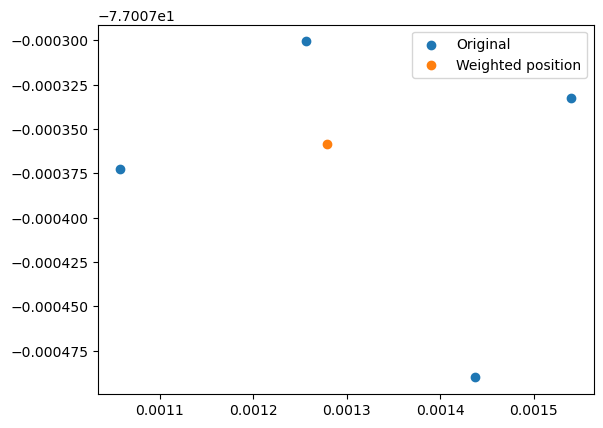

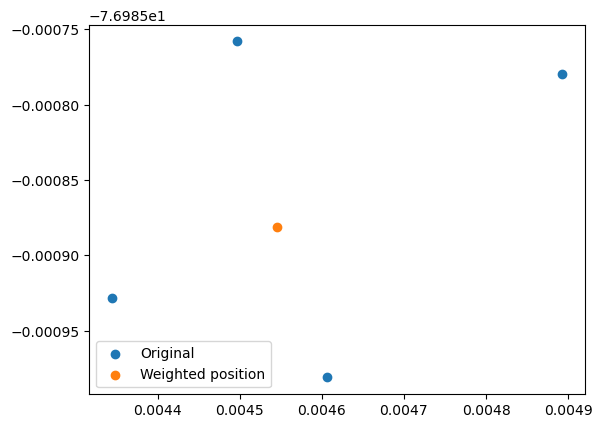

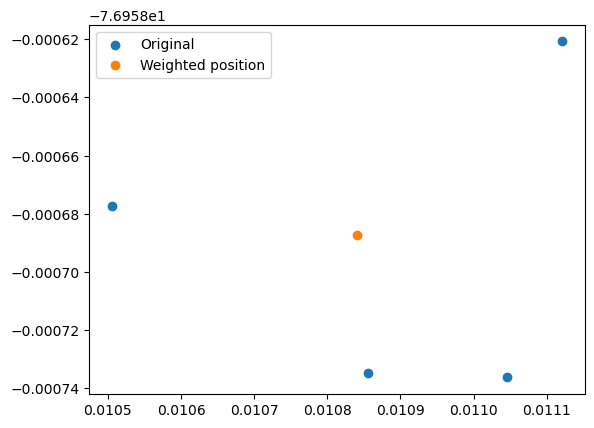

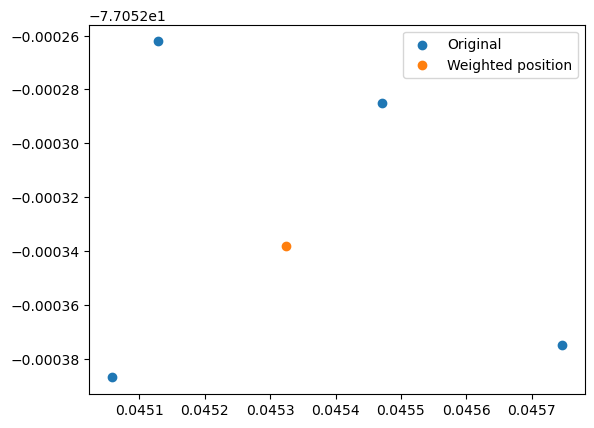

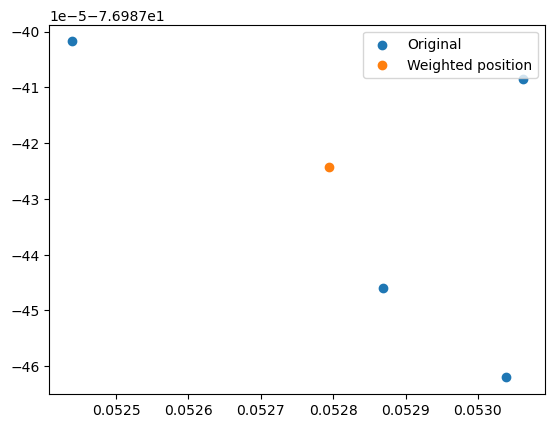

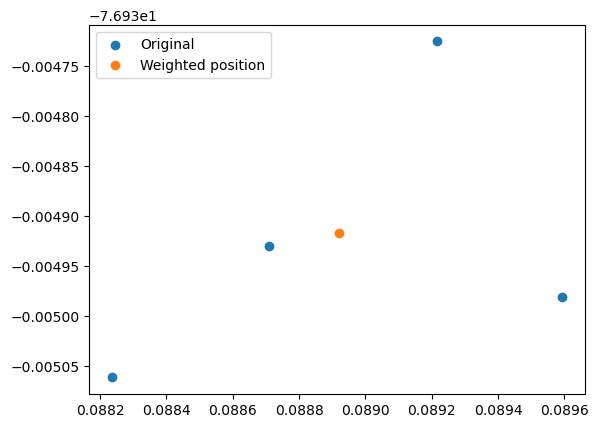

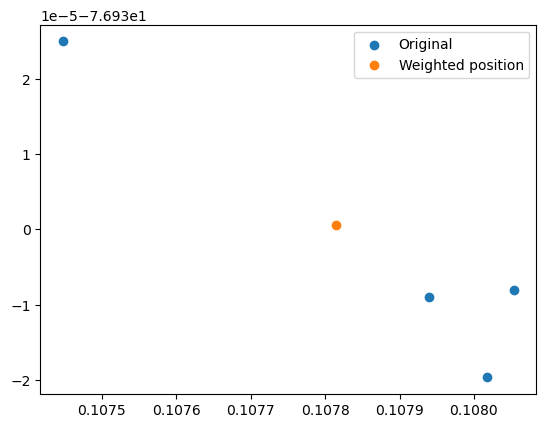

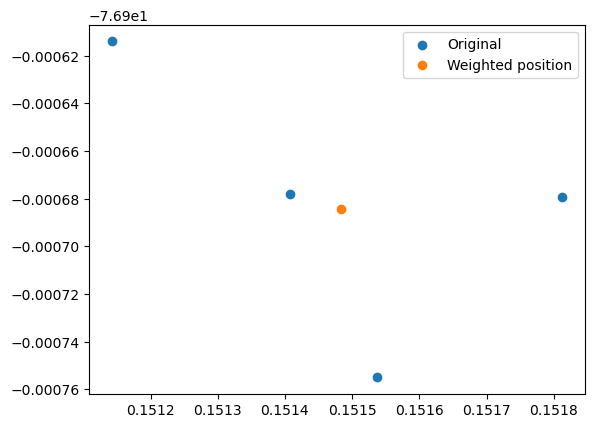

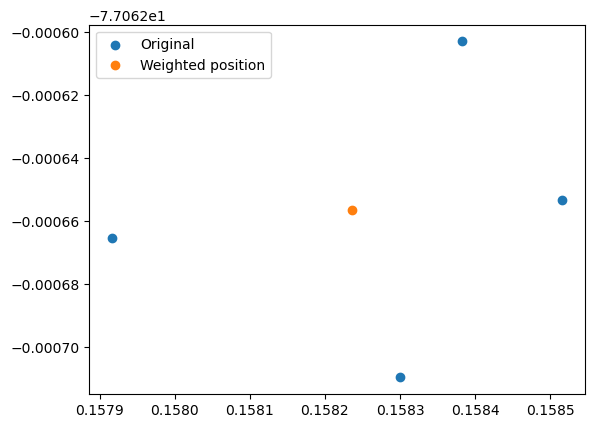

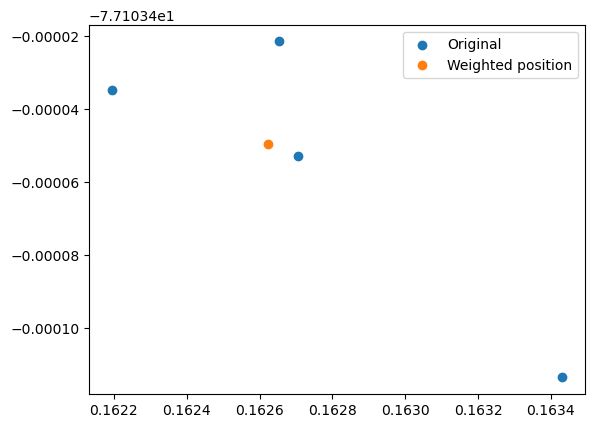

In [13]:
# Run test
filepath_src_uvot = roots_tfm + '/Swift-UVOT/uvot_ra_dec_per_src.fits'
df_source = Table.read(filepath_src_uvot).to_pandas()
filepath_uvot = roots_tfm + '/Swift-UVOT/uvot_ra_dec.fits'
df = Table.read(filepath_uvot).to_pandas()
list_test = df_source.loc[df_source['COUNT']>3,'SRCNUM'].head(10)
for i in list_test:
    plt.figure()
    plt.scatter(df.loc[df.loc[:,'SRCNUM']==i,'RA'],df.loc[df.loc[:,'SRCNUM']==i,'DEC'],color='C0',label='Original')
    plt.scatter(df_source.loc[df_source.loc[:,'SRCNUM']==i,'RA'],df_source.loc[df_source.loc[:,'SRCNUM']==i,'DEC'],color='C1',label='Weighted position')
    plt.legend()